In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from pathlib import Path
import torch

from matplotlib import pyplot as plt
import numpy as np

In [2]:
path = Path('/home/ec2-user/SageMaker/video_upscaling')
path_data = path/'data'/'DIV2K_train_HR'
path_bi = path/'data'/'bi'

In [3]:
il = (ImageList.from_folder(path_data)
     #       .use_partial_data(sample_pct=.05, seed=42)
     )

In [4]:
def crappify(fn, i, path, size):
    dest = path/fn.relative_to(path_data)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    img = PIL.Image.open(fn)
    targ_size = resize_to(img, size, use_min=True)
    img = img.resize(targ_size, resample=PIL.Image.BILINEAR).convert('RGB')
    targ_size = resize_to(img, 4*size, use_min=True)
    img = img.resize(targ_size, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
sets = [(path_bi, 128)]

for p, size in sets:
    if not p.exists():
        parallel(partial(crappify, path=p, size=size), il.items)

In [6]:
bs, size = 32, 128*4
arch = models.resnet34

src = ImageImageList.from_folder(path_bi).split_by_rand_pct(0.1, seed=42)

In [7]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_data/x.name)
               .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    return data

In [8]:
data = get_data(bs, size)

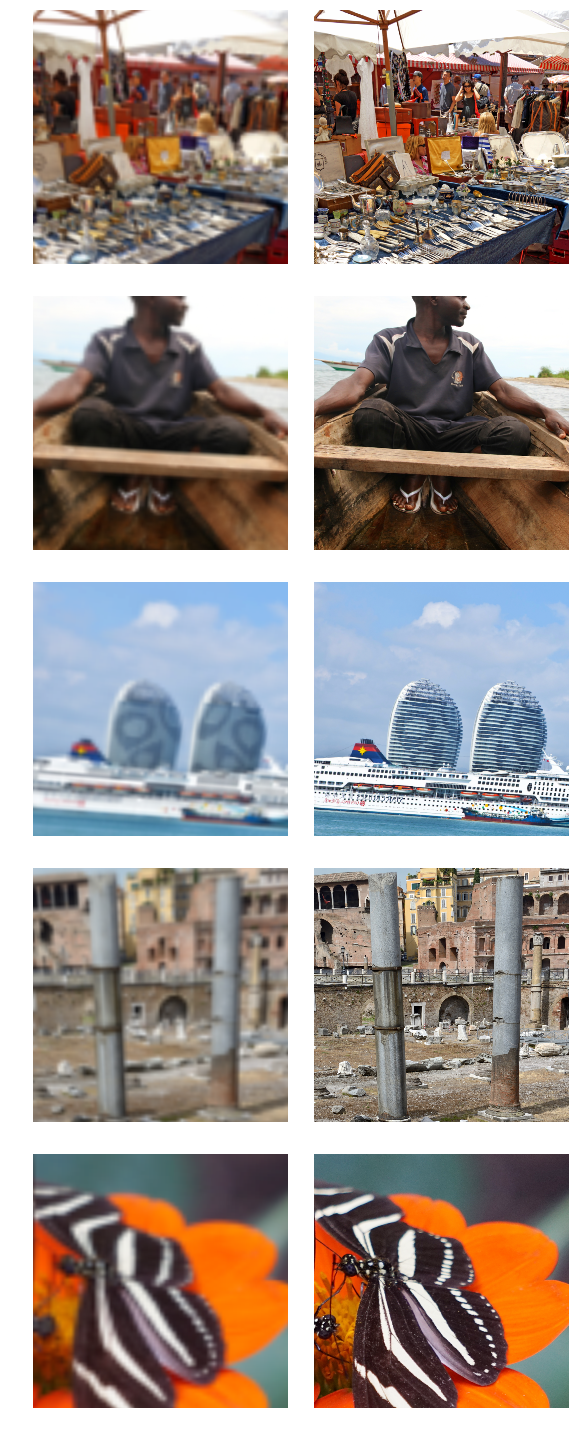

In [9]:
data.show_batch()

# Train 

In [10]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(9, 9), stride=1, padding=(3, 3))
        self.conv2 = nn.Conv2d(64, 32, kernel_size=(5, 5), stride=1, padding=(3, 3))
        self.conv3 = nn.Conv2d(32, 3, kernel_size=(5, 5), stride=1, padding=(2, 2))
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [11]:
srcnn = SRCNN().cuda()
srcnn

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [12]:
# create a stochastic gradient descent optimizer
optimizer = optim.Adam(srcnn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [13]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for batch_idx, (d, target) in enumerate(data.train_dl):
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = srcnn(d)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_idx % 8 == 7:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 8))
            running_loss = 0.0

print('Finished Training')
        

[1,     8] loss: 1.159
[1,    16] loss: 0.582
[2,     8] loss: 0.294
[2,    16] loss: 0.240
[3,     8] loss: 0.196
[3,    16] loss: 0.188
[4,     8] loss: 0.174
[4,    16] loss: 0.175
[5,     8] loss: 0.169
[5,    16] loss: 0.153
[6,     8] loss: 0.156
[6,    16] loss: 0.149
[7,     8] loss: 0.139
[7,    16] loss: 0.141
[8,     8] loss: 0.135
[8,    16] loss: 0.135
[9,     8] loss: 0.129
[9,    16] loss: 0.136
[10,     8] loss: 0.130
[10,    16] loss: 0.125
Finished Training


In [14]:
torch.save(srcnn.state_dict(), path/"srcnn_w_10_no_relu.pt")

In [9]:
srcnn = SRCNN().cuda()
srcnn.load_state_dict(torch.load(path/"srcnn_w.pt"), strict=False)

<All keys matched successfully>

In [10]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f53f06b86a0>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f53f0e11620>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=True)], collate_fn=<function data_collate at 0x7f53f311c598>)

In [15]:
mean = np.array([0.4850, 0.4560, 0.4060])
std = np.array([0.2290, 0.2240, 0.2250])
def prepere(l):
    l = l.cpu().numpy()
    l[0] = l[0] * std[0] + mean[0]
    l[1] = l[1] * std[1] + mean[1]
    l[2] = l[2] * std[2] + mean[2]
    l = np.transpose(l, (1,2,0))
    return l

In [16]:
mean = np.array([0.4850, 0.4560, 0.4060])
std = np.array([0.2290, 0.2240, 0.2250])
def prepere(l):
    l = l.cpu().numpy()
    l[0] = l[0] * std[0] + mean[0]
    l[1] = l[1] * std[1] + mean[1]
    l[2] = l[2] * std[2] + mean[2]
    l = np.transpose(l, (1,2,0))
    return l

In [17]:
def show_image(img):
    '''
    img: tensor
    '''
    img = prepere(img)
    plt.figure(figsize=(18,12))
    plt.imshow(img, cmap="brg")

In [18]:
dataiter = iter(data.train_dl)
images, labels = next(dataiter)


In [19]:
with torch.no_grad():
    preds = srcnn(images)

In [20]:
test_img = images[1]
ground_t = labels[1]
pred = preds[1]

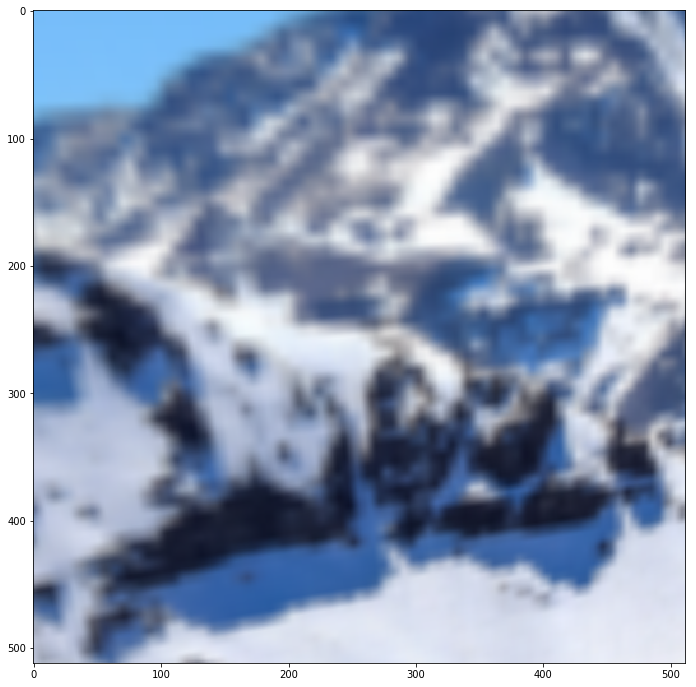

In [21]:
show_image(test_img)

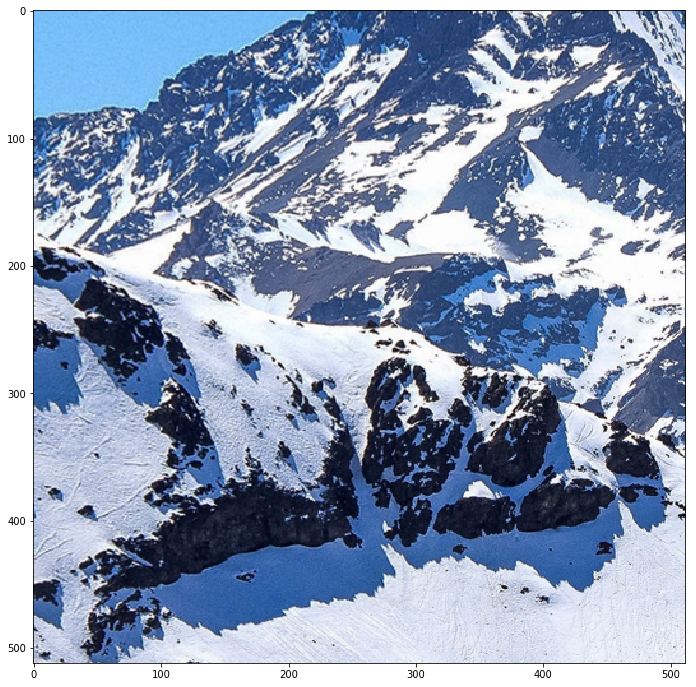

In [22]:
show_image(ground_t)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


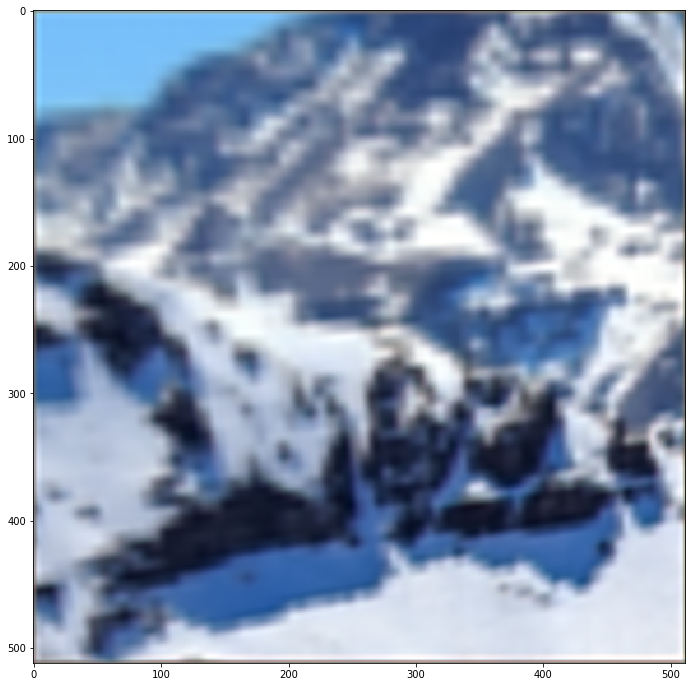

In [23]:
show_image(pred)

In [28]:
del srcnn
torch.cuda.empty_cache()

In [29]:
t = torch.cuda.get_device_properties(0).total_memory
c = torch.cuda.memory_cached(0)
a = torch.cuda.memory_allocated(0)
f = c-a  # free inside cache

In [30]:
f

0

In [37]:
a = [{1:2}]

In [38]:
s = a[0:]

In [39]:
s

[{1: 2}]

In [43]:
s[0] = 3

In [44]:
s

[3]

In [45]:
a

[{1: 3}]